### 构建Beale 公式及其导数

**导入相关模块**

In [162]:
import numpy as np
import matplotlib.pyplot as plt	
import matplotlib.colors as anaplt_cl

**构建相关函数**

In [163]:
# 定义beale公式
def beale(x1,x2):
    return (1.5-x1+x1*x2)**2+(2.25-x1+x1*x2**2)**2+(2.625-x1+x1*x2**3)**2
# 定义beale公式的偏导函数
def dbeale_dx(x1, x2):
    dfdx1 = 2*(1.5-x1+x1*x2)*(x2-1)+2*(2.25-x1+x1*x2**2)*(x2**2-1)+2*(2.625-x1+x1*x2**3)*(x2**3-1)
    dfdx2 = 2*(1.5-x1+x1*x2)*x1+2*(2.25-x1+x1*x2**2)*(2*x1*x2)+2*(2.625-x1+x1*x2**3)*(3*x1*x2**2)
    return dfdx1, dfdx2
# 计算R2损失 
def getR2Loss(lst):
    bestVal = [3, 0.5]
    bestY = beale(bestVal[0], bestVal[1])
    ans = []
    for pair in lst:
        x1 = float(pair[0])
        x2 = float(pair[1])
        y = beale(x1, x2)
        ans.append((y - bestY) ** 2)
    return ans

**可视化beale方程**

目标结果 (x_1, x_2) = (3, 0.5)


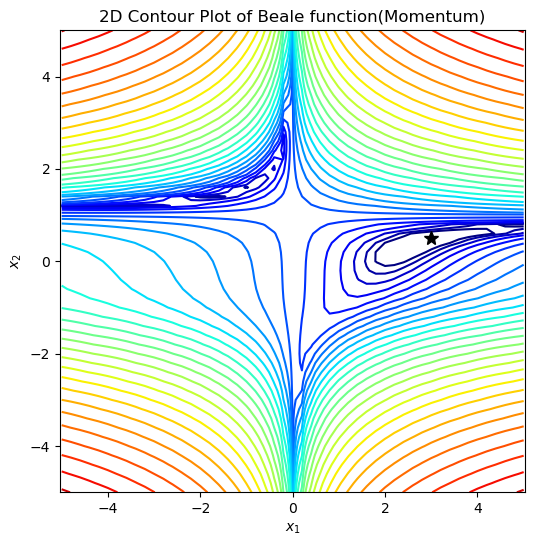

In [164]:
# 定义画图函数
def gd_plot(x_traj):
    plt.rcParams['figure.figsize'] = [6, 6]
    plt.contour(X1, X2, Y, levels=np.logspace(0, 6, 30),
                norm=anaplt_cl.LogNorm(), cmap=plt.cm.jet)
    plt.title('2D Contour Plot of Beale function(Momentum)')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.axis('equal')
    plt.plot(3, 0.5, 'k*', markersize=10)
    if x_traj is not None:
        x_traj = np.array(x_traj)
        plt.plot(x_traj[:, 0], x_traj[:, 1], 'k-')
    plt.show()

step_x1, step_x2 = 0.2, 0.2
X1, X2 = np.meshgrid(np.arange(-5, 5 + step_x1, step_x1),
                     np.arange(-5, 5 + step_x2, step_x2))
Y = beale(X1, X2)
print("目标结果 (x_1, x_2) = (3, 0.5)")
gd_plot(None)


### 编写SGD优化器并优化Beale 公式

**构建SGD优化器**

In [165]:
init_point = [-1,2]

In [166]:
def gd_sgd(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 设置学习率
    x_traj = []
    x_traj.append(x0)
    v = np.zeros_like(x0)
# 利用梯度值对坐标进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1]))
        v = - conf_para['learning_rate'] * dfdx
        x_traj.append(x_traj[-1] + v)
    return x_traj


**优化beale方程**

SGD求得极值点 (x_1, x_2) = (-2.363529592037631, 1.355159044091442)


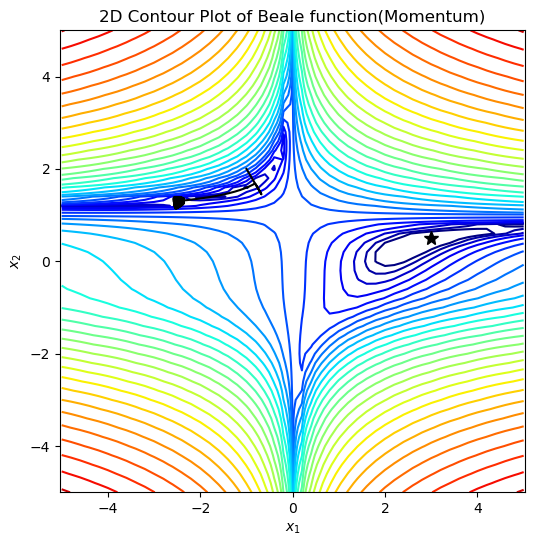

In [167]:
x0 = np.array(init_point)
conf_para_sgd = {'n_iter': 2000, 'learning_rate': 0.005}
x_traj_sgd = gd_sgd(dbeale_dx, x0, conf_para_sgd)
print("SGD求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_sgd[-1][0], x_traj_sgd[-1][1]))
gd_plot(x_traj_sgd) 
sgd_r2 = getR2Loss(x_traj_sgd)

### 编写动量优化器并优化Beale 公式

**构建Momentum优化器**

In [168]:
def gd_momentum(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 设置学习率
    conf_para.setdefault('momentum', 0.9)  # 设置动量参数
    x_traj = []
    x_traj.append(x0)
    v = np.zeros_like(x0)
# 套用动量优化器公式，对坐标值进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1]))
        v = conf_para['momentum'] * v - conf_para['learning_rate'] * dfdx
        x_traj.append(x_traj[-1] + v)
    return x_traj 

**优化beale方程**

Momentum求得极值点 (x_1, x_2) = (2.9999372260455415, 0.4999843312643237)


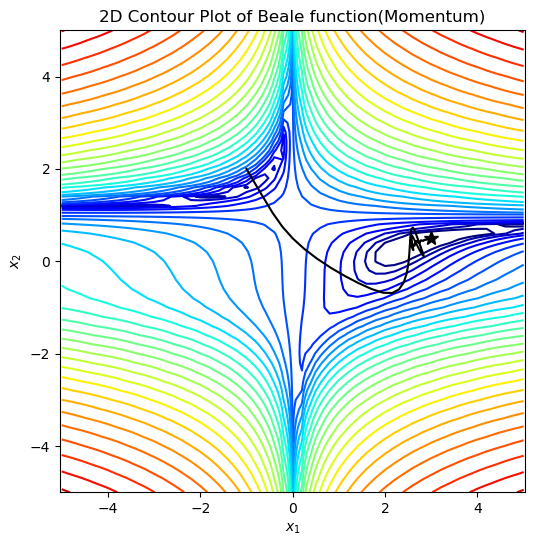

In [169]:
x0 = np.array(init_point)
conf_para_momentum = {'n_iter': 500, 'learning_rate': 0.005}
x_traj_momentum = gd_momentum(dbeale_dx, x0, conf_para_momentum)
print("Momentum求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_momentum[-1][0], x_traj_momentum[-1][1]))
gd_plot(x_traj_momentum) 
momentum_r2 = getR2Loss(x_traj_momentum)


### 编写自适应优化器并优化Beale 公式

**编写adagrad优化器**

In [170]:
def gd_adagrad(df_dx, x0, conf_para=None):
    if conf_para is None:
        conf_para = {}
    conf_para.setdefault('n_iter', 1000)  # 迭代次数
    conf_para.setdefault('learning_rate', 0.001)  # 学习率
    conf_para.setdefault('epsilon', 1e-7)
    x_traj = []
    x_traj.append(x0)
    r = np.zeros_like(x0).astype(float)
   # 套用adagrad优化器公式，对参数进行更新
    for iter in range(1, conf_para['n_iter'] + 1):
        dfdx = np.array(df_dx(x_traj[-1][0], x_traj[-1][1])).astype(float)
        r += dfdx ** 2
        x_traj.append(x_traj[-1] - conf_para['learning_rate'] / (np.sqrt(r) + conf_para['epsilon']) * dfdx)
    return x_traj 


**优化beale方程**

Adagrad求得极值点 (x_1, x_2) = (2.995518147486246, 0.49887458440755306)


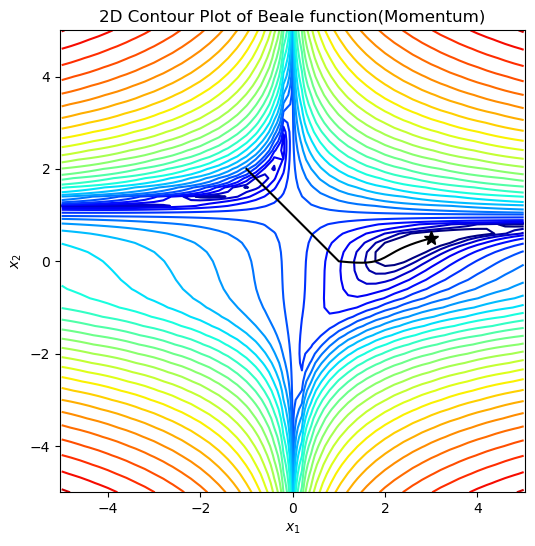

In [171]:
x0 = np.array(init_point)
conf_para_adag = {'n_iter': 500, 'learning_rate': 2}
x_traj_adag = gd_adagrad(dbeale_dx, x0, conf_para_adag)
print("Adagrad求得极值点 (x_1, x_2) = (%s, %s)" % (x_traj_adag[-1][0], x_traj_adag[-1][1]))
gd_plot(x_traj_adag) 
adagrad_r2 = getR2Loss(x_traj_adag)

### 评估R2

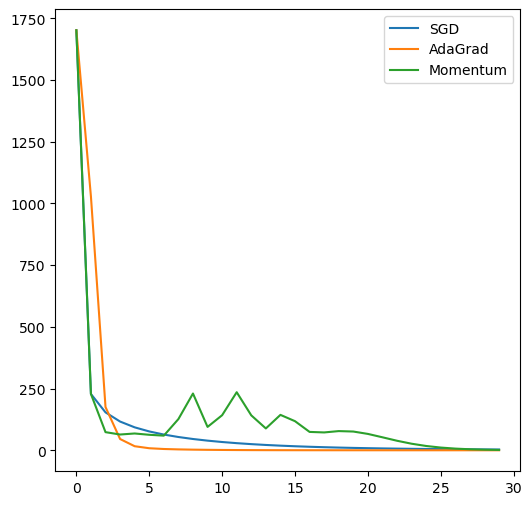

In [53]:
endPoint = 30
plt.plot(sgd_r2[:endPoint])
plt.plot(adagrad_r2[:endPoint])
plt.plot(momentum_r2[:endPoint])
plt.legend(["SGD", "AdaGrad", "Momentum"])

### 鸢尾花分类

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# CONFIG
batch = 8
epochs = 250
# 注意这个要调，改成False就会跑CNN的
isMLP = True
KERNAL_SIZE = 2
OUTPUT_CHANNEL = 16
data = pd.read_csv(r'iris.csv')
# 将鸢尾花种类由字母转换成数字
data['Species']=pd.factorize(data.Species)[0]
# 保存“萼片长度”，“萼片宽度”，“花瓣长度”，“花瓣宽度”
X = data.iloc[:,1:-1].values
# 保存鸢尾花种类
Y = data.Species.values
# CNN 需要(N, C, L)的数据
if isMLP == False:
    X = X.reshape(X.data.shape[0], 1, X.data.shape[1])
# 划分训练集和测试集 默认6：4
train_x,test_x,train_y,test_y=train_test_split(X,Y)
# 将numpy数据转换成tensor
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

# 创建训练集
train_ds = TensorDataset(train_x,train_y)
train_dl = DataLoader(train_ds,batch_size=batch,shuffle=True)
# 创建测试集
test_ds = TensorDataset(test_x,test_y)
test_dl = DataLoader(test_ds,batch_size=batch)

class MLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(True),
            nn.Linear(32, 32),
            nn.ReLU(True),
            nn.Linear(32, 3),
        )

    def forward(self,input):
        x = self.model(input)
        return x

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, OUTPUT_CHANNEL, kernel_size=KERNAL_SIZE),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=KERNAL_SIZE),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(3),
        )

    def forward(self,input):
        x = self.model(input)
        return x
    

class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(SGD, self).__init__(params, defaults)
    def step(self, closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                p.data.add_(grad, alpha=-lr)
                return loss
            
class AdamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, betas=(0.9, 0.999), eps = 1e-8):
        defaults = dict(lr=lr, betas=betas, eps = eps)
        super(AdamOptimizer, self).__init__(params, defaults)
    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # 获取基本参数
                grad = p.grad.data
                lr = group['lr']
                eps = group['eps']
                beta1, beta2 = group["betas"]
                state = self.state[p]
                # 初始化参数
                if len(state) == 0:
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                v = state['v']
                m = state['m']
                g_t = p.grad.data
                m_t = beta1 * m + (1 - beta1) * g_t
                v_t = beta2 * v + (1 - beta2) * g_t ** 2
                m_hat = m_t / (1 - beta1)
                v_hat = v_t / (1 - beta2)
                p.data.add_(m_hat / (eps + torch.sqrt(v_hat)), alpha = -lr)
                if closure is not None:
                    return closure()
class MomentumOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        # 调用父类构造函数
        super(MomentumOptimizer, self).__init__(params, defaults)
    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                lr = group['lr']
                momentum = group['momentum']
                state = self.state[p]
                if len(state) == 0:
                    state['velocity'] = torch.zeros_like(p.data)
                velocity = state['velocity']
                velocity.mul_(momentum).add_(grad)
                p.data.add_(velocity, alpha = -lr)
                if closure is not None:
                    return closure()


def accuracy(y_pred,y_true):
    # torch.argmax将数字转换成真正的预测结果
    y_pred = torch.argmax(y_pred,dim=1)
    acc = (y_pred == y_true).float().mean()
    return acc


def trainModel(model, loss_fn, optim):
    train_loss=[]
    train_acc=[]
    test_loss=[]
    test_acc=[]
    for epoch in range(epochs):
        # 训练
        for x,y in train_dl:
            model.train()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        # 测试
        with torch.no_grad():
            model.eval()
            epoch_accuracy = accuracy(model(train_x),train_y)       # 训练集准确率
            epoch_loss = loss_fn(model(train_x), train_y).data      # 训练集loss
            epoch_test_accuracy = accuracy(model(test_x),test_y)    # 测试集准确率
            epoch_test_loss = loss_fn(model(test_x), test_y).data   # 测试集loss
            if epoch % 50 == 0:
                print('epoch: ',epoch,'train_loss: ',round(epoch_loss.item(),3),'train_accuracy: ',round(epoch_accuracy.item(),3),
                    'test_loss: ',round(epoch_test_loss.item(),3),'test_accuracy: ',round(epoch_test_accuracy.item(),3)
                    )
            train_loss.append(epoch_loss)
            train_acc.append(epoch_accuracy)
            test_loss.append(epoch_test_loss)
            test_acc.append(epoch_test_accuracy)
    print('final test_accuracy: ',epoch_test_accuracy)
    return train_loss, train_acc, test_loss, test_acc, float(epoch_test_accuracy)

# 画图
def drawFig(train_loss, train_acc, test_loss, test_acc, path, final_test_acc):
    plt.cla()
    plt.plot(range(1,epochs+1),train_loss,label='train_loss')
    plt.plot(range(1,epochs+1),test_loss,label='test_loss')
    plt.plot(range(1,epochs+1),train_acc,label='train_acc')
    plt.plot(range(1,epochs+1),test_acc,label='test_acc')
    plt.legend()
    plt.title(path + "  final_testacc: " + str(final_test_acc))
    plt.savefig(path)

## Config
LR = 0.0001
if isMLP:
    ## MLP + SGD_Write
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = SGD(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_SGD_Write", final_test_acc)
    ## MLP + Adam_Write
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = AdamOptimizer(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_Adam_Write", final_test_acc)
    ## MLP + Momentum_Write
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = MomentumOptimizer(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_Momentum_Write", final_test_acc)
    ## MLP + Adam
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.Adam(model.parameters(),lr=LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_Adam", final_test_acc)
    ## MLP + SGD
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.SGD(model.parameters(),lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_SGD", final_test_acc)
    ## MLP + Momentum
    model = MLPModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.SGD(params=model.parameters(),lr=LR, momentum=0.9)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "MLP_Momentum", final_test_acc)
else:
    ## CNN + SGD_Write
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = SGD(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_SGD_Write", final_test_acc)
    ## CNN + Adam_Write
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = AdamOptimizer(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_Adam_Write", final_test_acc)
    ## CNN + Momentum_Write
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = MomentumOptimizer(model.parameters(), lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_Momentum_Write", final_test_acc)
    ## CNN + Adam
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.Adam(model.parameters(),lr=LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_Adam", final_test_acc)
    ## CNN + SGD
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.SGD(model.parameters(),lr = LR)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_SGD", final_test_acc)
    ## CNN + Momentum
    model = CNNModel()
    loss_fn = nn.CrossEntropyLoss()
    optim_adam = torch.optim.SGD(params=model.parameters(),lr=LR, momentum=0.9)
    train_loss, train_acc, test_loss, test_acc, final_test_acc= trainModel(model, loss_fn, optim_adam)
    drawFig(train_loss, train_acc, test_loss, test_acc, "CNN_Momentum", final_test_acc)